# Multi-frequency FDFD
### Introductory example

Reproduces the unoptimized structure in J. Wang et al., "Adjoint-based optimization of active nanophotonic devices", Optics Express 26(3), 2018.\
Underlying physics: Z. Yu and S. Fan, "Complete optical isolation created by indirect interband photonic transitions", Nature Photonics 3(2), 2009.\
By Siddharth Buddhiraju (www.siddharthbuddhiraju.com, siddharthb@alumni.stanford.edu)

In [165]:
import numpy as np
import autograd.numpy as npa
import skimage as sk
import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle, circle_perimeter

import sys
sys.path.append('/Users/siddharthb/Google Drive/Research/invdes/mf/ceviche/ceviche')
import ceviche
from ceviche import fdfd_ez, fdfd_mf_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode
# from ceviche.helper import operator_proj, operator_blur 

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [170]:
# Speed of light in vacuum
c0 = 3e+8
# Angular frequency of the source in Hz
# omega = 2*np.pi*243*1e12
omega=243e12 #rad/s and not THz, typo in the actual paper
# Modulation frequency 
Omega=132e12 #rad/s and not THz, typo in the actual paper
# Number of sidebands on each side of central wavelength (total number of bands: 2*Nsb + 1)
Nsb = 1
# Spatial resolution in meters
dl=50e-9
# Number of pixels in the PMLs in each direction
Npml=10
# Background permittivity
eps_bg=1.0
# Waveguide structure's relative permittivity
eps_si=12.25
# Modulation depth
mod_depth=1.0
# Modulation phases
mod_phi_l = 0
mod_phi_r = np.pi/2
# Number of modulation frequencies (different from number of sidebands) 
Nfreq = 1
# Full width of simulation domain
W=4e-6
# Waveguide thickness
wg_width=1.1e-6
# Central section thickness
wc=2.0e-6
# Full length of simulation domain
L=55e-6
# Length of modulation region on each side
Lmod=19e-6
#Length of central section
Lmid=4.75e-6
# Number of pixels in x-direction
Nx=int(L/dl)
# Number of pixels in y-direction
Ny=int(W/dl) 
# Space between the PMLs and the design region (in pixels)
space=20
# Length in pixels of the source/probe slices on each side of the center point
slice_width=3*wg_width

print('Simulation domain is ' + str(Nx) + 'x' + str(Ny) + ' pixels')

Simulation domain is 1100x80 pixels


In [171]:
def init_domain():
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    
    # Permittivity initialization of the structure
    epsr = eps_bg*np.ones((Nx, Ny))

    ## Waveguide
    # Left waveguide section
    wg_L1 = 0
    wg_L2 = int(Nx/2) - int(Lmid/2/dl)
    # Right waveguide section
    wg_R1 = int(Nx/2) + int(Lmid/2/dl)
    wg_R2 = int(Nx)
    wg_top = int(Ny/2) + int(wg_width/2/dl)
    wg_bot = int(Ny/2) - int(wg_width/2/dl)
    #Central section
    wg_c_top = int(Ny/2) + int(wc/2/dl)
    wg_c_bot = int(Ny/2) - int(wc/2/dl)
    
    epsr[wg_L1:wg_L2, wg_bot:wg_top] = eps_si
    epsr[wg_R1:wg_R2, wg_bot:wg_top] = eps_si
    epsr[wg_L2:wg_R1, wg_c_bot:wg_c_top] = eps_si

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1), 
        y=np.arange(int(Ny/2) - int(slice_width/2/dl), int(Ny/2) + int(slice_width/2/dl)))
    
    # Output probe slice
    output_slice = Slice(x=np.array(Nx-Npml-1), 
        y=np.arange(int(Ny/2) - int(slice_width/2/dl), int(Ny/2) + int(slice_width/2/dl)))
    
    # Modulation region
    delta = np.zeros((Nfreq, Nx, Ny))
    delta[:, wg_L2-int(Lmod/dl):wg_L2, int(Ny/2):wg_top] = mod_depth
    delta[:, wg_R1:wg_R1+int(Lmod/dl), int(Ny/2):wg_top] = mod_depth
    phi = np.zeros((Nfreq, Nx, Ny))
    phi[:, wg_L2-int(Lmod/dl):wg_L2, int(Ny/2):wg_top] = mod_phi_l
    phi[:, wg_R1:wg_R1+int(Lmod/dl), int(Ny/2):wg_top] = mod_phi_r
    return epsr, input_slice, output_slice, delta, phi


def poynting_flux(Hy, Ez, field_slice):
    S = -0.5 * Ez * npa.conj(Hy)
    Sr = npa.real(S*1e20)
    power_out = np.zeros(2*Nsb+1)
    for band in np.arange(-Nsb,Nsb+1):
        power_out[band+Nsb] = np.sum(Sr[band+Nsb][field_slice.x][field_slice.y])
    return power_out

### Forward propagation (Fig. 1c)
Does not result in good conversion from first even mode to first odd mode

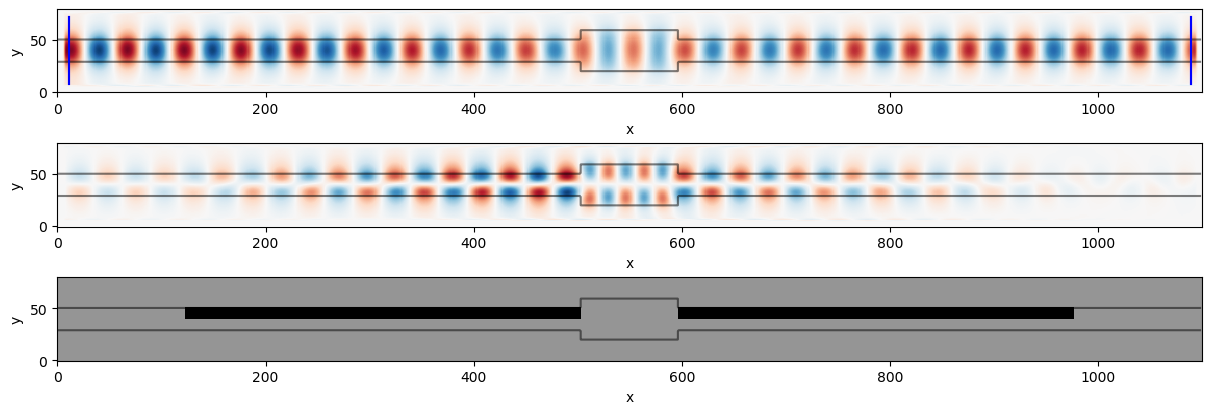

In [174]:
# Initialize the parametrization rho and the design region
epsr, input_slice, output_slice, delta, phi = init_domain()

# Setup source and pad appropriately
# Insert source at input slice
source_0 = np.array([insert_mode(omega, dl, input_slice.x, input_slice.y, epsr, m=1)])
pad_left = np.zeros([Nsb,Nx,Ny])
pad_right = np.zeros([Nsb,Nx,Ny])
source = np.concatenate( (np.concatenate((pad_left, source_0)), pad_right) )

simulation = fdfd_mf_ez(omega, dl, epsr, Omega, delta, phi, Nsb, [Npml, Npml])
slices = [input_slice, output_slice]
Hx, Hy, Ez = simulation.solve(source)
fig, ax = plt.subplots(3,1, constrained_layout=True, figsize=(12,4))
ceviche.viz.real(Ez[Nsb + 0], outline=epsr, ax=ax[0], cbar=False)
ceviche.viz.real(Ez[Nsb + 1,:], outline=epsr, ax=ax[1], cbar=False)    
for sl in slices:
    ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
    ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
ceviche.viz.real(delta[0], outline=epsr, ax=ax[2], cmap='Greys')

### Backward propagation (Fig. 1d)
Good conversion efficiency from first even mode to first odd mode.

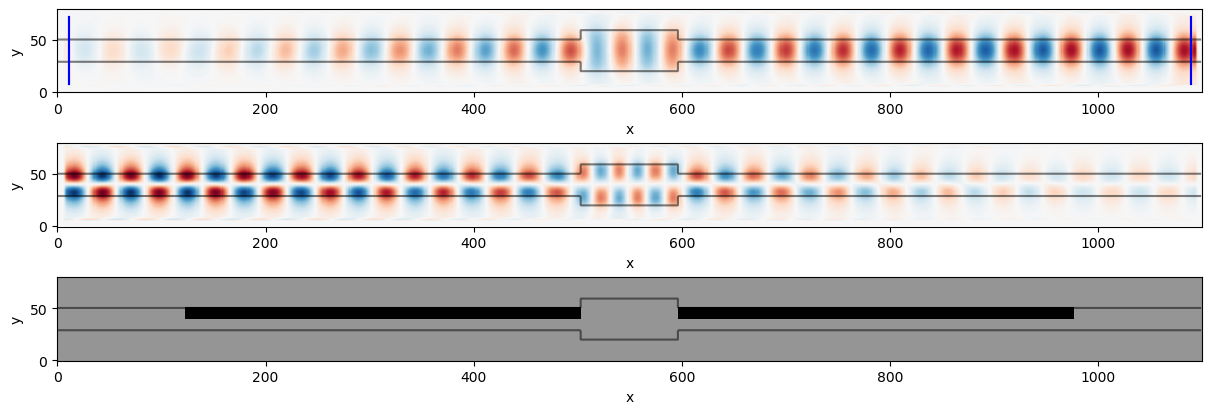

In [175]:
# Initialize the parametrization rho and the design region
epsr, input_slice, output_slice, delta, phi = init_domain()

# Setup source and pad appropriately
# Insert source at output slice
source_0 = np.array([insert_mode(omega, dl, output_slice.x, output_slice.y, epsr, m=1)]) 
pad_left = np.zeros([Nsb,Nx,Ny])
pad_right = np.zeros([Nsb,Nx,Ny])
source = np.concatenate( (np.concatenate((pad_left, source_0)), pad_right) )

simulation = fdfd_mf_ez(omega, dl, epsr, Omega, delta, phi, Nsb, [Npml, Npml])
slices = [input_slice, output_slice]
Hx, Hy, Ez = simulation.solve(source)
fig, ax = plt.subplots(3,1, constrained_layout=True, figsize=(12,4))
ceviche.viz.real(Ez[Nsb + 0], outline=epsr, ax=ax[0], cbar=False)
ceviche.viz.real(Ez[Nsb + 1,:], outline=epsr, ax=ax[1], cbar=False)    
for sl in slices:
    ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
    ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
ceviche.viz.real(delta[0], outline=epsr, ax=ax[2], cmap='Greys')